In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import glob, sys

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import *
from plotting_utils import *
from lineplots import plotsd
from stabilizer_utils import *
from recalibration_utils import *
from session_utils import *

from CosineTuning import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


min_nblocks    = 2
max_ndays      = 1e99
participant    = 'T5'


FILE_DIR       = '/oak/stanford/groups/shenoy/ghwilson/nonstationarities/' + participant + '/'
fig_path       = '/home/users/ghwilson/projects/nonstationarities/figures/'
filelist       = glob.glob(FILE_DIR + 'historical/*')
filelist.extend(glob.glob(FILE_DIR + 'new/*'))

block_constraints = getBlockConstraints(FILE_DIR)

files          = get_Sessions(filelist, min_nblocks,  block_constraints = block_constraints)
pairs          = get_SessionPairs(files, max_ndays = max_ndays)
n_pairs        = len(pairs)

In [2]:

    
    

def plotAngleDifferences(x, angles, colors, labels = None, alpha = None):
    '''Plot angular differences across time. Inputs are:
    
        x (1D float array)    - nSamples of x-axis values 
        angles (2D float)     - nSamples x nClasses of angles 
        colors (1D str array) - nClasses of colors 
        labels (1D str array) - nClasses of labels
        
    '''
    
    nClasses = angles.shape[1]
    
    if labels == None:
        labels = [None] * nClasses
    
    for i in range(nClasses):
        y = angles[:, i]
        plt.scatter(x, y, alpha = alpha, color = colors[i], label = labels[i])

    plt.ylabel('Tuning similarity (Cos $\theta$)')
    plt.axhline(0, c = 'k', linestyle = '--')
    plt.ylim([-1, 1])
    plt.legend()

In [3]:
from joblib import Parallel, delayed
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import warnings


def search_regularization(reg_opts, x_train, y_train):
    
    tuned_params = {'alpha' : reg_opts}
    clf          = GridSearchCV(Ridge(), tuned_params).fit(x_train, y_train)
    
    return clf.best_estimator_


def processSingleSession(file, cfg):
    
    session_dict = dict()
    fields       = ['TX', 'cursorPos', 'targetPos']
    
    # First calculate encoding and decoding weights independently for each session:
    session = DataStruct(file, causal_filter = cfg['sigma'], alignScreens = True)
    blocks  = block_constraints[file]

    # obtain features and cursorError targets:
    session_dat = getTrainTest(session, fields = fields, train_size = cfg['train_size'], 
                               task = cfg['task'], blocks = blocks, returnFlattened = True)    
    train_y     = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
    test_y      = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])

    reference_means = session_dat['test_TX'][-1].mean(axis = 0)
    train_x, test_x = subtractMeans(session_dat['train_TX'], session_dat['test_TX'],
                                    method = 'blockwise', concatenate = True)

    # train encoders and decoders
    #decoder         = Ridge(alpha = reg_strength, normalize = False).fit(train_x, train_y)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        decoder      = search_regularization(cfg['reg_opts'], train_x, train_y)
        test_decoder = search_regularization(cfg['reg_opts'], test_x, test_y)
        score        = decoder.score(test_x, test_y)

    encoder         = fitEncodingMatrix(train_y, train_x, fitMean = False)[0]
    test_encoder    = fitEncodingMatrix(test_y, test_x, fitMean = False)[0]

    # measure within-session bias changes:
    bias_index_test  = estimateNormalizedBias(decoder, test_x, test_y, threshold = 300)
    bias_index_train = estimateNormalizedBias(decoder, train_x, train_y, threshold = 300)
    session_dict['normalized_bias_index']         = bias_index_test
    session_dict['normalized_bias_index_control'] = bias_index_train
    
    # small check on effect of within-session bias adjustment on metric
    bias_index_train_no_empirical = estimateNormalizedBias(decoder, train_x, train_y, threshold = 300,
                                                          empirical_correction = False)
    session_dict['normalized_bias_index_control_no_empirical_correction'] = bias_index_train_no_empirical

    # measure within-session PD changes:
    encoder_angles, encoder_overall = estimateSubspaceDrift(encoder[1:, :], 
                                                            test_encoder[1:, :])
    decoder_angles, decoder_overall = estimateSubspaceDrift(decoder.coef_, 
                                                            test_decoder.coef_)

    session_dict['encoder_angles'] = encoder_angles
    session_dict['decoder_angles'] = decoder_angles
    session_dict['combined_decoder_angle'] = decoder_overall

    session_dict['dates']         = deepcopy(session.date)
    session_dict['decoder_means'] = reference_means
    session_dict['scores']   = score
    session_dict['encoders'] = encoder
    session_dict['decoders'] = decoder
    
    return session_dict

In [4]:
# general settings:
np.random.seed(42)
cfg = dict()

cfg['task']         = None
cfg['train_size']   = 0.5
cfg['sigma']        = 2
cfg['reg_opts']     = [1e1, 1e3, 1e5, 1e7, 1e9]

# --------------------------------------------------
uniqueFiles     = np.unique(np.concatenate(pairs))

dict_list   = Parallel(n_jobs=-1, verbose = 5)(delayed(processSingleSession)(file, cfg) for file in uniqueFiles)

session_dict = dict()
for key in dict_list[0].keys():
    session_dict[key] = list()
    for d in dict_list:
        session_dict[key].append(d[key])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  49 out of  73 | elapsed:  2.9min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  64 out of  73 | elapsed:  3.3min remaining:   28.1s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:  3.4min finished


Within-session analyses:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


--------Effect of empirical correction on bias index --------
Mean +- SD of difference:  0.20082213662865103 0.273595033282799
Mean of relative difference: 0.4184546060074165
Wilcoxon test of differences: p = 3.169E-13


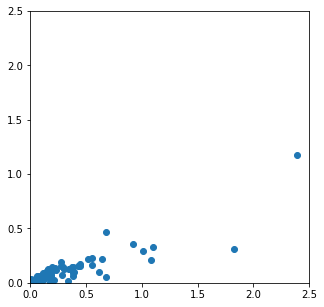

In [5]:
# first check if the empirical correction for bias index has a noticeable effect

print('--------Effect of empirical correction on bias index --------')
with_correction = np.asarray(session_dict['normalized_bias_index_control'])
no_correction   = np.asarray(session_dict['normalized_bias_index_control_no_empirical_correction'])
diffs           = no_correction - with_correction
print('Mean +- SD of difference: ', np.mean(diffs), np.std(diffs))
print('Mean of relative difference:', np.mean(diffs / no_correction))
print('Wilcoxon test of differences: p = {:.3E}'.format(scipy.stats.wilcoxon(diffs)[1]))

figSize(5, 5)
plt.scatter(no_correction, with_correction)
plt.xlim([0, 2.5])
plt.ylim([0, 2.5])
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


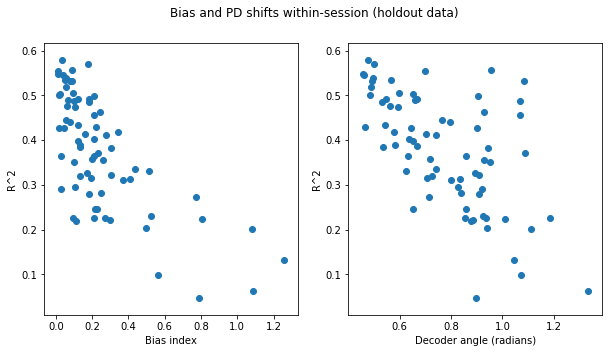

                  Multivariate linear model
                                                             
-------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value  Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.1371 2.0000 70.0000 220.2732 0.0000
         Pillai's trace 0.8629 2.0000 70.0000 220.2732 0.0000
 Hotelling-Lawley trace 6.2935 2.0000 70.0000 220.2732 0.0000
    Roy's greatest root 6.2935 2.0000 70.0000 220.2732 0.0000
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
          scores         Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.4181 2.0000 70.0000 48.7057 0.0000
          Pillai's trace 0.5819 2.0000 70.0000 48.7057 0.0000
  Hotelling-Lawley trace 1

In [6]:
# now plot bias index and PD shift angle on test set within-session:
import pandas as pd 

figSize(5, 10)

plt.subplot(1, 2, 1)
plt.scatter(session_dict['normalized_bias_index'], session_dict['scores'])
plt.xlabel('Bias index')
plt.ylabel('R^2')

plt.subplot(1, 2, 2)
plt.scatter(session_dict['combined_decoder_angle'], session_dict['scores'])
plt.xlabel('Decoder angle (radians)')
plt.ylabel('R^2')

plt.suptitle('Bias and PD shifts within-session (holdout data)')
plt.show()

import statsmodels.api as sm
from statsmodels.formula.api import ols

keys = ['scores', 'normalized_bias_index', 'combined_decoder_angle']
df   = dict()
for key in keys:
    df[key] = session_dict[key]
df = pd.DataFrame(df)

#perform MANOVA
from statsmodels.multivariate.manova import MANOVA
fit = MANOVA.from_formula('normalized_bias_index + combined_decoder_angle ~ scores', data=df)
print(fit.mv_test())

-------- Within-session ---------
Normalized bias index (control): 0.117 +- 0.154
Normalized bias index (test): 0.241 +- 0.257
Wilcoxon test of differences: p = 1.044E-07


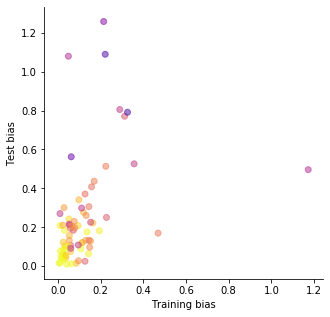

In [7]:
import matplotlib as mpl 
import matplotlib.cm as cm

norm = mpl.colors.Normalize(vmin=0, vmax=0.5)
cmap = cm.plasma
m    = cm.ScalarMappable(norm=norm, cmap= cmap)


print('-------- Within-session ---------')

mean = np.mean(session_dict['normalized_bias_index_control'])
SD   = np.std(session_dict['normalized_bias_index_control'])
print('Normalized bias index (control): {:.3f} +- {:.3f}'.format(mean, SD))

mean = np.mean(session_dict['normalized_bias_index'])
SD   = np.std(session_dict['normalized_bias_index'])
print('Normalized bias index (test): {:.3f} +- {:.3f}'.format(mean, SD))

bias_diffs = np.asarray(session_dict['normalized_bias_index']) - np.asarray(session_dict['normalized_bias_index_control'])
print('Wilcoxon test of differences: p = {:.3E}'.format(scipy.stats.wilcoxon(bias_diffs)[1]))


figSize(5, 5)
colors = m.to_rgba(session_dict['scores'])

plt.scatter(session_dict['normalized_bias_index_control'], session_dict['normalized_bias_index'], c = colors, alpha = 0.5)
plt.xlabel('Training bias')
plt.ylabel('Test bias')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig(fig_path + 'SNR/T5_bias_withinsession_comparison', format = 'pdf')
plt.show()

Now look at across-session drift:

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


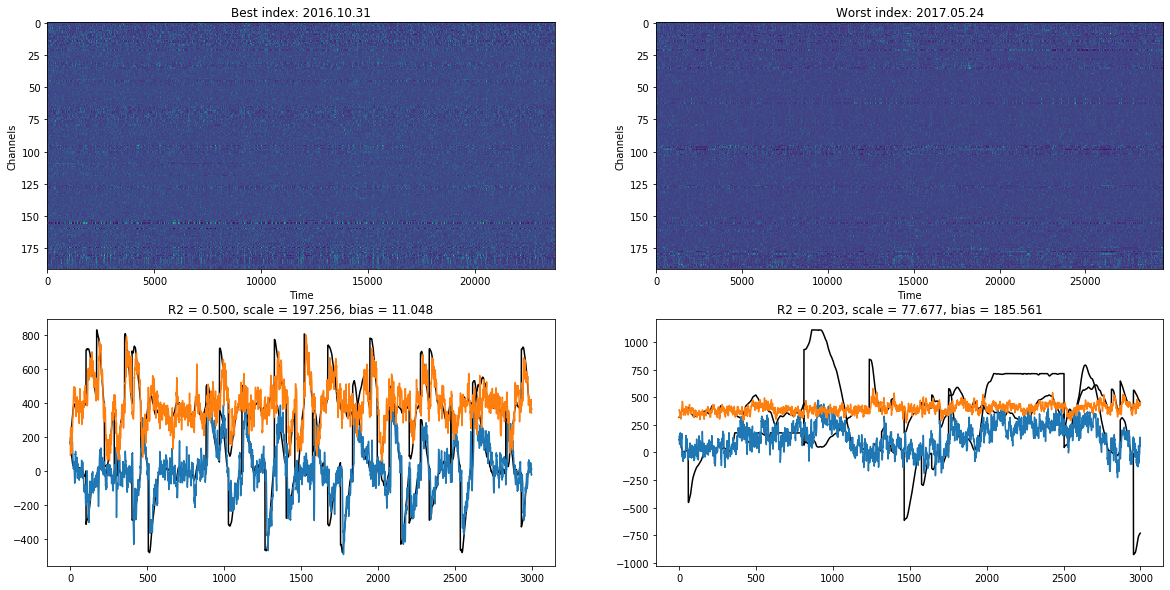

In [9]:
figSize(12, 18)

best_idx  = np.argmin(session_dict['normalized_bias_index_control'])
worst_idx = np.argmax(session_dict['normalized_bias_index_control'])
labels    = ['Best index', 'Worst index']

fields  = ['TX', 'cursorPos', 'targetPos']
for i, idx in enumerate([best_idx, worst_idx]):
    file    = uniqueFiles[idx]
    session = DataStruct(file, causal_filter = cfg['sigma'], alignScreens = True)
    blocks  = block_constraints[file]
    
    # obtain features and cursorError targets:
    session_dat = getTrainTest(session, fields = fields, train_size = cfg['train_size'], 
                               task = cfg['task'], blocks = blocks, returnFlattened = True)    
    train_y     = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
    test_y      = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])
    
    # 
    reference_means = session_dat['test_TX'][-1].mean(axis = 0)
    train_x, test_x = subtractMeans(session_dat['train_TX'], session_dat['test_TX'],
                                    method = 'blockwise', concatenate = True)
    decoder         = Ridge(alpha = 1e7, normalize = False).fit(train_x, train_y)
    encoder         = fitEncodingMatrix(train_y, train_x, fitMean = False)[0]
    score           = decoder.score(test_x, test_y)
    
    scale, bias    = fitLinearModel(train_y, decoder.predict(train_x), threshold = 300)
    
    plt.subplot(2, 2, i + 1)
    
    plt.imshow(train_x.T, aspect = 'auto')
    plt.title(labels[i] + ': ' + session.date)
    plt.xlabel('Time')
    plt.ylabel('Channels')
    
    plt.subplot(2, 2, i + 1 + 2)
    window = np.arange(2000, 5000) + 3000
    offset = np.asarray([0, 400])
    plt.plot(train_y[window] + offset, color = 'k')
    plt.plot(decoder.predict(train_x[window]) + offset)
    plt.title('R2 = {:.3f}, scale = {:.3f}, bias = {:.3f}'.format(score, scale, np.linalg.norm(bias)))

plt.show()


In [10]:
def generatePairData(A_file, B_file, cfg):
    
    dict_fields = ['reference date', 'new date', 'days apart', 'encoder angles', 'decoder angles', 'combined decoder angle', 
               'full recal score', 'meanrecal score', 'norecal score', 'normalized_bias_index']
    scores_dict = dict()
    
    for key in dict_fields:
        scores_dict[key] = list()
    
    # metadata 
    A_date   = A_file.split('t5.')[1].split('.mat')[0]
    B_date   = B_file.split('t5.')[1].split('.mat')[0]

    scores_dict['reference date'].append(A_date)
    scores_dict['new date'].append(B_date)
    scores_dict['days apart'].append(daysBetween(A_date, B_date))

    A_ind  = np.where(np.in1d(session_dict['dates'], A_date))[0][0]
    B_ind  = np.where(np.in1d(session_dict['dates'], B_date))[0][0]

    # angular drift metrics
    
    encoder_angles, encoder_overall = estimateSubspaceDrift(session_dict['encoders'][A_ind][1:, :], 
                                                            session_dict['encoders'][B_ind][1:, :])
    
    decoder_angles, decoder_overall = estimateSubspaceDrift(session_dict['decoders'][A_ind].coef_, 
                                                            session_dict['decoders'][B_ind].coef_)
    
    scores_dict['encoder angles'].append(encoder_angles)
    scores_dict['decoder angles'].append(decoder_angles)
    scores_dict['combined decoder angle'].append(decoder_overall)


    # functional metrics - offline R^2  
    scores_dict['full recal score'].append(session_dict['scores'][B_ind])

    session = DataStruct(B_file, causal_filter = cfg['sigma'], alignScreens = True)

    # obtain features and cursorError targets:
    fields          = ['TX', 'cursorPos', 'targetPos']
    session_dat     = getTrainTest(session, fields = fields, train_size = cfg['train_size'], task = cfg['task'], returnFlattened = True)    
    train_y         = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
    test_y          = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])

    # 
    train_x, test_x = subtractMeans(session_dat['train_TX'], session_dat['test_TX'], 
                                    method = 'blockwise', concatenate = True)
    meanrecal_score = session_dict['decoders'][A_ind].score(test_x, test_y)
    scores_dict['meanrecal score'].append(meanrecal_score)  

    # 
    test_x  = np.concatenate(session_dat['test_TX']) - session_dict['decoder_means'][A_ind][None, :]

    norecal_score = session_dict['decoders'][A_ind].score(test_x, test_y) 
    scores_dict['norecal score'].append(norecal_score)

    bias_index  = estimateNormalizedBias(session_dict['decoders'][A_ind], test_x, test_y, threshold = 300)
    scores_dict['normalized_bias_index'].append(bias_index)
    
    return scores_dict


In [11]:
from joblib import Parallel, delayed
import pandas as pd


dict_list   = Parallel(n_jobs=-1, verbose = 1)(delayed(generatePairData)(*arg, cfg) for arg in pairs)
scores_dict = pd.DataFrame(dict_list).to_dict()

for key, value in scores_dict.items():
    scores_dict[key] = np.concatenate(list(value.values()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 2410 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2628 out of 2628 | elapsed:  6.6min finished


No handles with labels found to put in legend.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


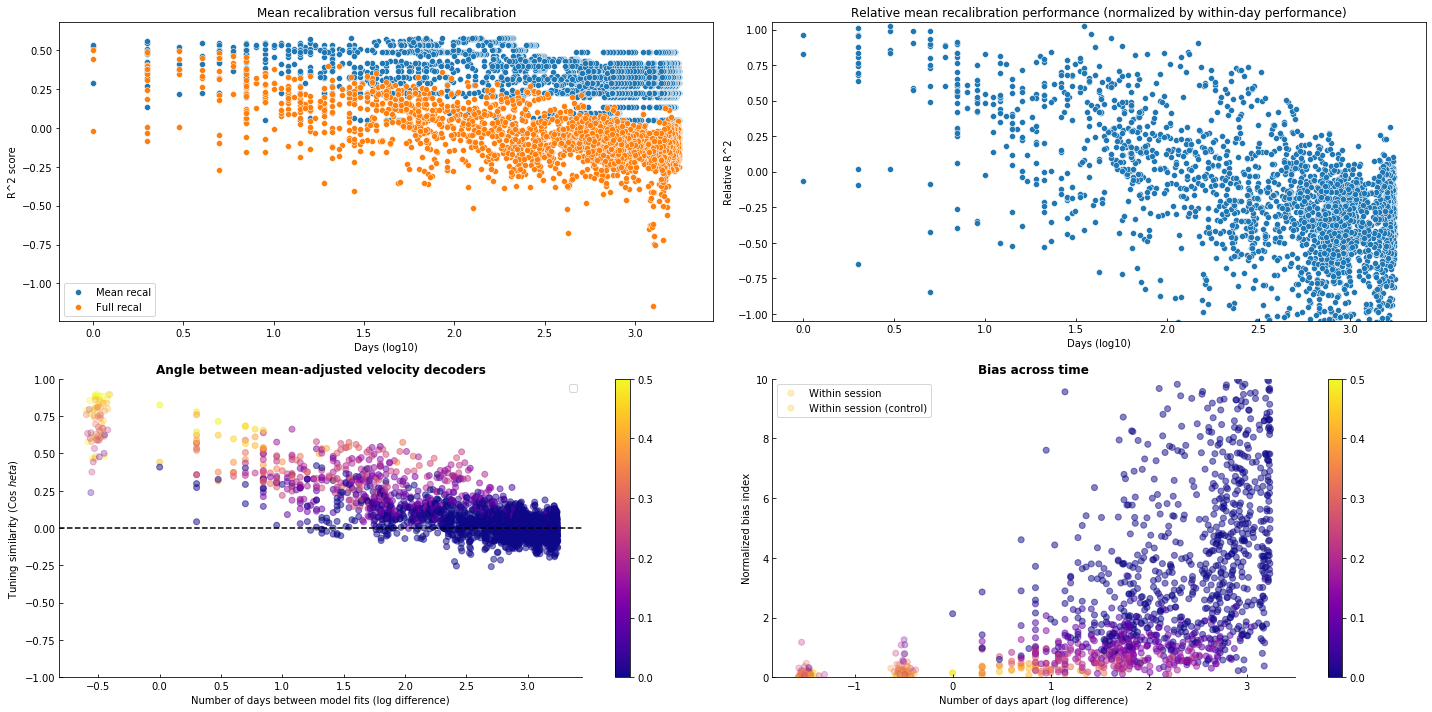

In [12]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm

# define colormap based on R2 value
norm = mpl.colors.Normalize(vmin=0, vmax=0.5)
cmap = cm.plasma
m    = cm.ScalarMappable(norm=norm, cmap= cmap)

# optionally subselect points 
#subselect = np.logical_and(scores[:, 0] > 0, scores[:, 1] > 0)
#scores    = np.asarray(scores)
#subselect = np.arange(scores.shape[0])
subselect = np.arange(n_pairs)

figSize(10, 20)

plt.subplot(2, 2, 1)
sns.scatterplot(x = np.log10(scores_dict['days apart']), y = scores_dict['full recal score'])
sns.scatterplot(x = np.log10(scores_dict['days apart']), y = scores_dict['meanrecal score'])
plt.legend(['Mean recal', 'Full recal'])
plt.title('Mean recalibration versus full recalibration')
plt.xlabel('Days (log10)')
plt.ylabel('R^2 score')

plt.subplot(2, 2, 2)
y = np.asarray(scores_dict['meanrecal score']) / np.asarray(scores_dict['full recal score'])

sns.scatterplot(x = np.log10(scores_dict['days apart']), y = y)
plt.ylim([-1.05, 1.05])
plt.title('Relative mean recalibration performance (normalized by within-day performance)')
plt.xlabel('Days (log10)')
plt.ylabel('Relative R^2')
ax = plt.gca()
ax.tick_params(direction = 'in')

# PD shift across time
plt.subplot(2, 2, 3)

alpha     = 0.5

x         = np.asarray(scores_dict['days apart'])[subselect]
sort_idx  = np.argsort(x)
x         = np.log10(x[sort_idx])
y     = np.cos(np.vstack(scores_dict['combined decoder angle'])[subselect, :][sort_idx])
colors = [m.to_rgba(np.asarray(scores_dict['meanrecal score'])[subselect][sort_idx])]

plotAngleDifferences(x, y, colors, None, alpha)
plt.xlabel('Number of days between model fits (log difference)')
plt.title('Angle between mean-adjusted velocity decoders', fontweight = 'bold')
plt.colorbar(m)
ax = plt.gca()
ax.tick_params(direction = 'in')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# within-session 
y_session = np.cos(np.asarray(session_dict['combined_decoder_angle']))
y_session = y_session[y_session > 0]
x_session = np.random.normal(-0.5, 0.05, y_session.shape)
colors = m.to_rgba(session_dict['scores'])

plt.scatter(x_session, y_session, c = colors, alpha = 0.3, label = 'Within session')


# ======== Bias across time ==========
plt.subplot(2, 2, 4)
y = np.asarray(scores_dict['normalized_bias_index'])
x = np.asarray(scores_dict['days apart'])
x = np.log10(x)
colors = m.to_rgba(np.asarray(scores_dict['norecal score']))

plt.scatter(x[y < 10], y[y < 10], c = colors[y < 10], alpha = alpha )

# within-session: test
colors    = m.to_rgba(session_dict['scores'])

y_session = np.asarray(session_dict['normalized_bias_index'])
x_session = np.random.normal(-0.5, 0.05, y_session.shape)
plt.scatter(x_session, y_session, c = colors, alpha = 0.3, label = 'Within session')

# within-session: train
y_session = np.asarray(session_dict['normalized_bias_index_control'])
x_session = np.random.normal(-1.5, 0.05, y_session.shape)
plt.scatter(x_session, y_session, c = colors, alpha = 0.3, label = 'Within session (control)')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yscale('linear')
ax.set_xscale('linear')
ax.tick_params(direction = 'in')

plt.ylim([-0.001, 10])
plt.xlabel('Number of days apart (log difference)')
plt.ylabel('Normalized bias index')
plt.legend()
plt.title('Bias across time', fontweight = 'bold')
plt.colorbar(m)

plt.tight_layout()
plt.savefig(fig_path + 'SNR/T5_EncDec_Drift.pdf', format = 'pdf')
plt.show()

In [63]:
daterange = [7, 14]


print('Within-day:')
print('R2 values:', np.median(session_dict['scores']))
print('Angle values:', np.median(session_dict['decoder_angles']) * 180/ np.pi)
print('R2 values:',  np.median(session_dict['scores']))

idxs   = np.logical_and(scores_dict['days apart'] >= daterange[0], scores_dict['days apart'] <= daterange[1])
biases = scores_dict['normalized_bias_index'][idxs]
angles = scores_dict['combined decoder angle'][idxs]
R2s    = scores_dict['meanrecal score'][idxs]
print('\nBias index values in', f'{daterange[0]}-{daterange[1]} days range:', np.median(biases))
print('Angle values in', f'{daterange[0]}-{daterange[1]} days range:', np.median(angles) * 180 / np.pi)
print('R2 values in', f'{daterange[0]}-{daterange[1]} days range:', np.median(R2s))

Within-day:
R2 values: 0.3866024448594706
Angle values: 43.16183917607428
R2 values: 0.3866024448594706

Bias index values in 7-14 days range: 0.7783078543028492
Angle values in 7-14 days range: 70.61600437902239
R2 values in 7-14 days range: 0.2055855947554508


Supplementary images

In [96]:
years = np.asarray([x.split('.')[0] for x in session_dict['dates']])

years_ticks = dict()
years_ticks['idxs']  = np.concatenate([[0], np.where(years[:-1] != years[1:])[0] + 1])
years_ticks['years'] = years[years_ticks['idxs']]

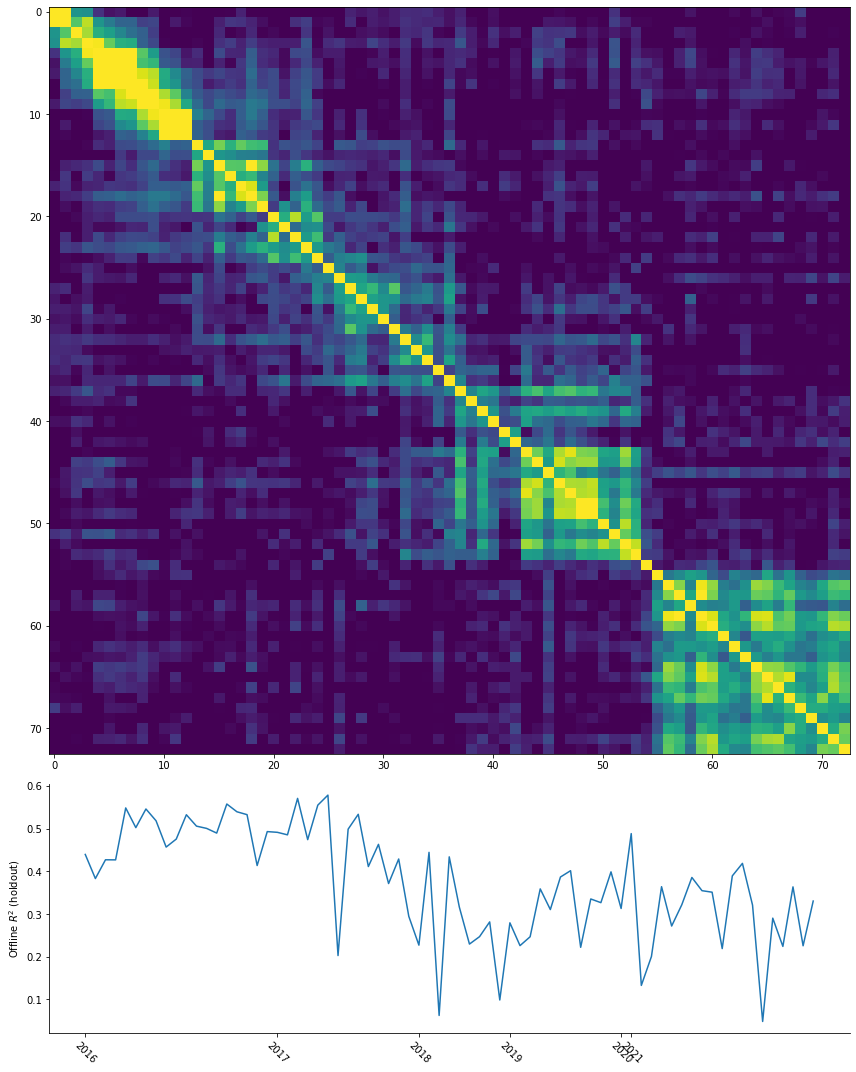

In [97]:

figSize(15, 12)
weights = np.vstack([x.coef_.flatten() for x in session_dict['decoders']])
corrmap = np.corrcoef(weights)

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

a0.imshow(corrmap, aspect = 'auto', vmin = 0, vmax = 0.6)
plt.xticks(None)

a1.plot(session_dict['scores'])
plt.xticks(years_ticks['idxs'], years_ticks['years'], rotation = 315)
plt.ylabel('Offline $R^2$ (holdout)')
a1.spines['top'].set_visible(False)
a1.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(fig_path + 'SNR/T5_decoder_overlap_matrix', format = 'pdf')
plt.show()

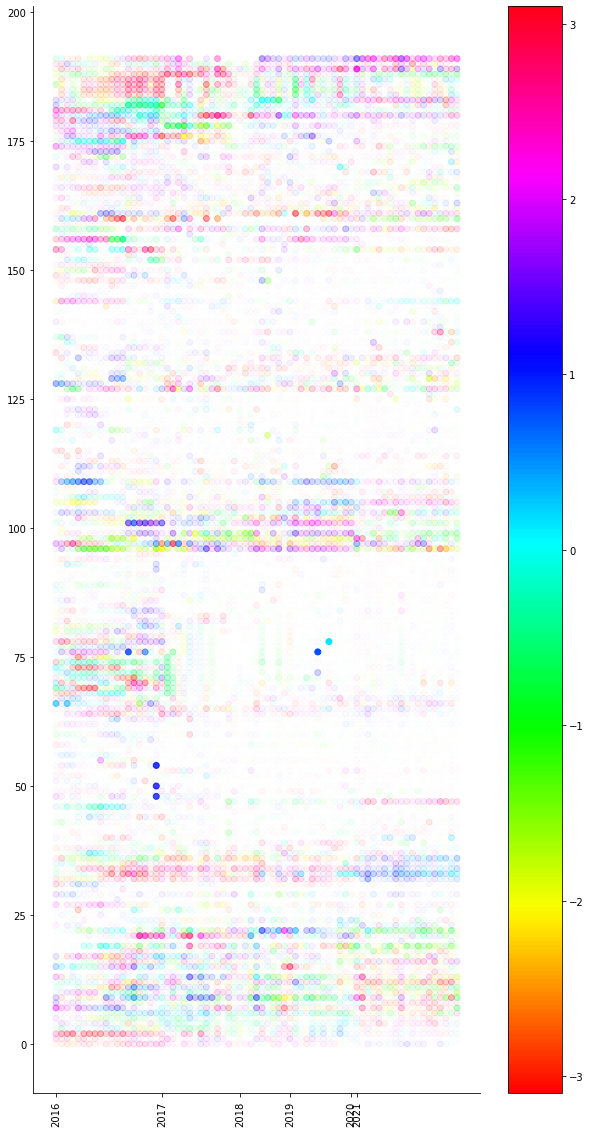

In [148]:
PDs = np.vstack([np.arctan2(enc[2, :], enc[1, :]) for enc in session_dict['encoders']])
snr = np.vstack([np.linalg.norm(enc[1:, :], axis = 0) for enc in session_dict['encoders']])


norm = mpl.colors.Normalize(vmin=-3.1, vmax=3.1)
cmap = cm.hsv
m    = cm.ScalarMappable(norm=norm, cmap= cmap)

colors = m.to_rgba(PDs)
colors[:, :, 3] = snr / 90

figSize(20, 10)

for chan in range(192):
    plt.scatter(np.arange(PDs.shape[0]), np.zeros(PDs.shape[0]) + chan, c = colors[:, chan, :])
    
plt.xticks(years_ticks['idxs'], years_ticks['years'], rotation = 90)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
plt.colorbar(m)
plt.savefig(fig_path + 'SNR/T5_PDs_across_time', format = 'pdf')
plt.show()

Changes within two weeks:

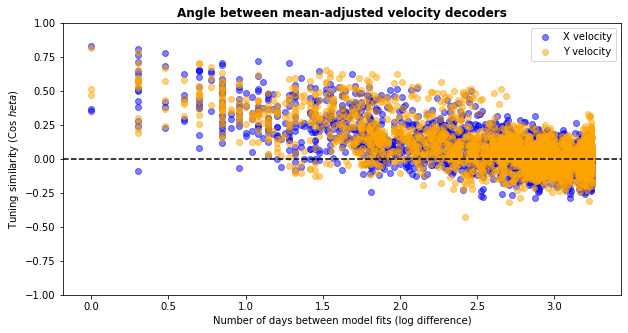

In [99]:
figSize(5, 10)

colors    = ['b', 'orange']
labels    = ['X velocity', 'Y velocity']
alpha     = 0.5

#subselect = np.logical_and(scores[:, 0] > 0, scores[:, 1] > 0)
#scores    = np.asarray(scores)
#subselect = np.arange(scores.shape[0])
subselect = np.arange(n_pairs)

x         = np.asarray(scores_dict['days apart'])[subselect]
sort_idx  = np.argsort(x)
x         = np.log10(x[sort_idx])
y         = np.cos(np.vstack(scores_dict['decoder angles'])[subselect, :][sort_idx, :])

plotAngleDifferences(x, y, colors, labels, alpha)
plt.xlabel('Number of days between model fits (log difference)')
plt.title('Angle between mean-adjusted velocity decoders', fontweight = 'bold')

plt.show()

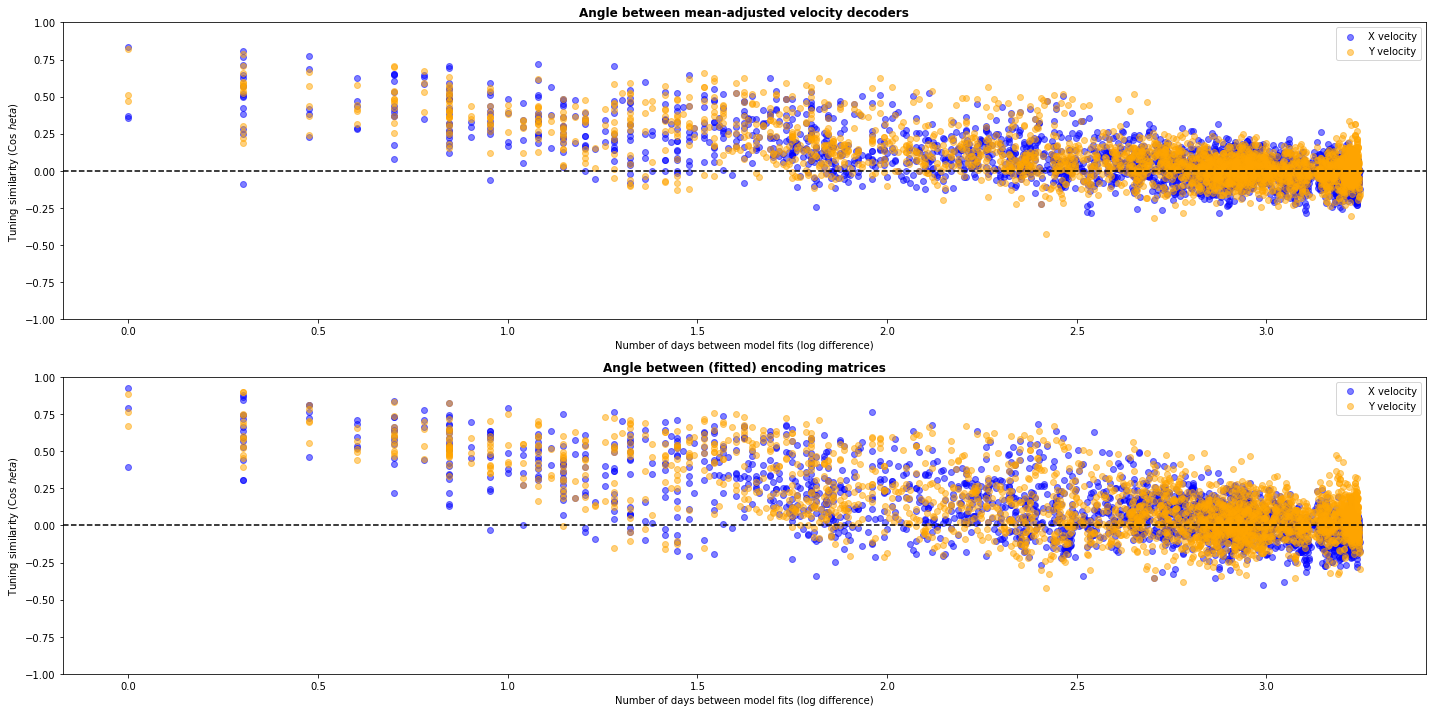

In [100]:
from scipy.signal import savgol_filter

figSize(10, 20)

n_iters   = 1000
colors    = ['b', 'orange']
labels    = ['X velocity', 'Y velocity']
alpha     = 0.5

#subselect = np.logical_and(scores[:, 0] > 0, scores[:, 1] > 0)
#scores    = np.asarray(scores)
#subselect = np.arange(scores.shape[0])
subselect = np.arange(n_pairs)

x         = np.asarray(scores_dict['days apart'])[subselect]
sort_idx  = np.argsort(x)
x         = np.log10(x[sort_idx])

# Decoders
plt.subplot(2, 1, 1)

y = np.cos(np.vstack(scores_dict['decoder angles'])[subselect, :][sort_idx, :])

plotAngleDifferences(x, y, colors, labels, alpha)
plt.xlabel('Number of days between model fits (log difference)')
plt.title('Angle between mean-adjusted velocity decoders', fontweight = 'bold')


# Encodings:
plt.subplot(2, 1, 2)

y = np.cos(np.vstack(scores_dict['encoder angles'])[subselect, :][sort_idx, :])

plotAngleDifferences(x, y, colors, labels, alpha)
plt.xlabel('Number of days between model fits (log difference)')
plt.title('Angle between (fitted) encoding matrices', fontweight = 'bold')


plt.tight_layout()
#plt.savefig(fig_path + 'SNR/T5_EncDec_Drift', format = 'pdf')
plt.show()


### Look at encoder drift model

Now we'll fit a linear model of our encoder drift across days with the formula:

$E' = \alpha E + \epsilon \ \ \ $     where $\epsilon \sim N(0, \sigma^{2}) $

This will help us determine plausible parameters for the closed-loop simulator by figuring out good values for the *shrinkage factor* $\alpha$ and noise model. Once we get the shrinkage factors for each pair of sessions, we can then fit some 
canonical shrinkage factor per day that helps compare these data across pairs (each pair may have e.g. 2 or 200 days apart). In this updated model, we have that:

$E^{(n)} = a^{n} E_{0} + \epsilon \ \ \ $ where $\epsilon \sim N(0, \sigma^{2} n * (\alpha^{n-1})^{2}) $

We can get this base shrinkage $\alpha$ value by performing linear regression on the observed shrinkages in log-space:

$\alpha_{x} \approx \hat{\alpha} = \exp(c \cdot x )$

$c = argmin_{a_{0}} ||\log(\alpha_{x}) - x * log(\alpha_{0}) ||^{2} $

Base alpha =  0.9127546639283498
Base alpha =  0.9250748939988905


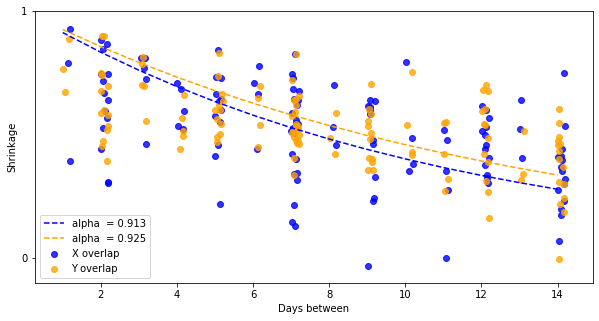

In [101]:
def fitDecayModel(x, y):
    
    pos_mask = y > 0
        
    x_filt = x[pos_mask][:, np.newaxis]
    y_filt = y[pos_mask][:, np.newaxis]
    
    mult  = np.linalg.lstsq(x_filt, np.log(y_filt), rcond = None)[0][0][0]
    alpha = np.exp(mult)
    
    return alpha

figSize(5, 10)
window = 14 # look at sessions up to two weeks apart
colors = ['b', 'orange']
labels = ['X overlap', 'Y overlap']


withinWindow      = np.where(scores_dict['days apart'] <= window)[0]
withinDiffs       = scores_dict['days apart'][withinWindow]

for i in range(2):
    withinShrinkages  = np.cos(scores_dict['encoder angles'][withinWindow, i])
    alpha  = fitDecayModel(withinDiffs, withinShrinkages) 
    print('Base alpha = ', alpha)
    
    x = np.arange(1, max(withinDiffs) + 1)
    y = alpha**x
    plt.scatter(withinDiffs + (0.2 * np.random.rand(*withinDiffs.shape)), withinShrinkages, alpha = 0.8, color = colors[i], label = labels[i])
    plt.plot(x, y, color = colors[i], linestyle = '--', label = 'alpha  = ' + str(np.round(alpha, 3)))

plt.ylim([-0.1, 1])
plt.yticks([0, 1])
plt.xlabel('Days between')
plt.ylabel('Shrinkage')
plt.legend()
#plt.savefig(fig_path + 'SNR/T5_Enc_drift_twoweeks', format = 'pdf')
plt.show()